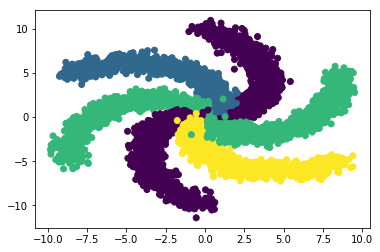

In [8]:
## Creating Data

import numpy as np
import matplotlib.pyplot as plt
def get_spiral():
    # Idea: radius -> low...high
    #           (don't start at 0, otherwise points will be "mushed" at origin)
    #       angle = low...high proportional to radius
    #               [0, 2pi/6, 4pi/6, ..., 10pi/6] --> [pi/2, pi/3 + pi/2, ..., ]
    # x = rcos(theta), y = rsin(theta) as usual

    radius = np.linspace(1, 10, 1000)
    thetas = np.empty((6, 1000))
    for i in range(6):
        start_angle = np.pi*i / 3.0
        end_angle = start_angle + np.pi / 2
        points = np.linspace(start_angle, end_angle, 1000)
        thetas[i] = points

    # convert into cartesian coordinates
    x1 = np.empty((6, 1000))
    x2 = np.empty((6, 1000))
    for i in range(6):
        x1[i] = radius * np.cos(thetas[i])
        x2[i] = radius * np.sin(thetas[i])

    # inputs
    X = np.empty((6000, 2))
    X[:,0] = x1.flatten()
    X[:,1] = x2.flatten()

    # add noise
    X += np.random.randn(6000, 2)*0.5

    # targets
    Y = np.array([0]*1000 + [1]*1000 + [2]*1000 + [0]*1000 + [3]*1000 + [2]*1000)
    return X, Y

X,y=get_spiral()

plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

## Processing the Data

def one_hot_encoder(X):
    N=X.shape[0]
    K=len(np.unique(X))
    Z=np.zeros((N,K))
    for i in range(N):
        c=int(X[i])
        Z[i,c]=1
    return Z
y_i=one_hot_encoder(y)

def standardize(X):
    stds=X.std(axis=0)
    means=X.mean(axis=0)
    X=(X-means)/stds
    return X,means,stds

X_s,m,s=standardize(X)

def train_test_split(X,y,size=0.8,rs=None):
    N=len(X)
    np.random.seed(rs)
    tr_i=np.random.choice(N,int(size*N),replace=False)
    t_i=[i for i in range(N) if i not in tr_i]
    X_train=X[tr_i]
    y_train=y[tr_i]
    X_test=X[t_i]
    y_test=y[t_i]
    return X_train,y_train,X_test,y_test
X_train,y_train,X_test,y_test=train_test_split(X_s,y,size=0.9,rs=20)

In [9]:
X_train=X_train.astype(np.float32)
y_train=y_train.astype(np.float32)
X_test=X_test.astype(np.float32)
y_test=y_test.astype(np.float32)

In [24]:
X_train.shape

(5400, 2)

In [10]:
import tensorflow as tf

In [90]:
class HiddenLayer(object):
    def __init__(self,i,M1,M2,p_keep,af='relu',rs=None):
        self.id=i
        self.M1=M1
        self.M2=M2
        self.af=af
        self.p_keep=p_keep
        self.W=tf.Variable(tf.random_normal(shape=[M1,M2],stddev=np.sqrt(2/M1),seed=rs,dtype=tf.float32))
        self.b=tf.Variable(tf.random_normal(shape=[M2],seed=rs,dtype=tf.float32))
        self.params=[self.W,self.b]
    def forward(self,X,type='train'):
        if type=='train':
            X=tf.nn.dropout(X,self.p_keep)
        if self.af=='tanh':
            return tf.nn.tanh(tf.matmul(X,self.W)+self.b)
        if self.af=='sigmoid':
            return tf.nn.sigmoid(tf.matmul(X,self.W)+self.b)
        if self.af=='relu':
            return tf.nn.relu(tf.matmul(X,self.W)+self.b)
        if self.af=='leaky-relu':
            return tf.nn.leaky_relu(tf.matmul(X,self.W)+self.b)

In [105]:
class ANN(object):
    def __init__(self,hidden_layer_size,p_keep_io,p_keep_hl):
        self.hidden_layer_size=hidden_layer_size
        self.p_keep_io=p_keep_io
        self.p_keep_hl=p_keep_hl

    def forward(self,X,type='train'):
        z=X
        for h in self.hidden_layers:
            z=h.forward(z,type)
        if type=='train':
            z=tf.nn.dropout(z,self.p_keep_io)
        return tf.matmul(z,self.W)+self.b
    
    def predict(self,X):
        p=self.forward(X,'pred')
        return tf.argmax(p,axis=1)
    
    def fit(self,X,y,beta=0.999,mu=0.95,e=1e-9,lr=0.001,epochs=1000,af=None,fig=True,batch_size=2900,n_batch=10,random_state=None):
        if af==None:
            af=len(self.hidden_layer_size)*['relu']
        X_t,y_t,X_v,y_v=train_test_split(X,y,size=0.9,rs=random_state)
        c_t=[]
        c_v=[]
        cl_t=[]
        cl_v=[]
        N,D=X_t.shape
        print(N)
        self.hidden_layers=[]
        M1=D
        cnt=0
        M2=self.hidden_layer_size[0]
        h=HiddenLayer(i=cnt,M1=M1,M2=M2,af=af[0],p_keep=self.p_keep_io,rs=random_state)
        self.hidden_layers.append(h)
        M1=M2
        cnt+=1
        for M2,a in zip(self.hidden_layer_size[1:],af[1:]):
            h=HiddenLayer(i=cnt,M1=M1,M2=M2,p_keep=self.p_keep_io,af=a,rs=random_state)
            self.hidden_layers.append(h)
            M1=M2
            cnt+=1
        M2=len(set(y))
        self.W=tf.Variable(tf.random_normal([M1,M2],stddev=np.sqrt(2/M1),seed=random_state,dtype=tf.float32))
        self.b=tf.Variable(tf.random_normal(shape=[M2],seed=random_state,dtype=tf.float32))
        self.params=[self.W,self.b]
        for h in self.hidden_layers:
            self.params+=h.params
        tfX=tf.placeholder(tf.float32,shape=[None,D])
        tfY=tf.placeholder(tf.int32,shape=[None,])
        y_p=self.forward(tfX)
        cost=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_p,labels=tfY))
        preds=self.predict(tfX)
        optimizer=tf.train.RMSPropOptimizer(lr,decay=beta,momentum=mu,epsilon=e)
        train=optimizer.minimize(cost)
        with tf.Session() as s:
            s.run(tf.global_variables_initializer())
            for i in range(epochs):
                for j in range(n_batch):
                    x=X_t[j*batch_size:(j*batch_size+batch_size)]
                    yb=y_t[j*batch_size:j*batch_size+batch_size]
                    c_t.append(s.run(cost,feed_dict={tfX:x,tfY:yb}))
                    c_v.append(s.run(cost,feed_dict={tfX:X_v,tfY:y_v}))
                    cl_t.append(np.mean(s.run(preds,feed_dict={tfX:x})==yb))               
                    cl_v.append(np.mean(s.run(preds,feed_dict={tfX:X_v})==y_v))    
#                     cl_t.append(np.mean(s.run(preds,feed_dict={tfX:x})==np.argmax(yb,axis=1)))               
#                     cl_v.append(np.mean(s.run(preds,feed_dict={tfX:X_v})==np.argmax(y_v,axis=1)))
                    s.run(train,feed_dict={tfX:x,tfY:yb})
#                 c_t.append(s.run(cost,feed_dict={tfX:X_t,tfY:y_t}))
#                 c_v.append(s.run(cost,feed_dict={tfX:X_v,tfY:y_v}))
#                 cl_t.append(np.mean(s.run(preds,feed_dict={tfX:X_t})==np.argmax(y_t,axis=1)))               
#                 cl_v.append(np.mean(s.run(preds,feed_dict={tfX:X_v})==np.argmax(y_v,axis=1)))    
#                 s.run(train,feed_dict={tfX:X_t,tfY:y_t})   
                if i%10==0:
                    print('Epoch {0} Train C: {1} Cl: {2} Test C: {3} Cl:{4}'.format(i,c_t[i],cl_t[i],c_v[i],cl_v[i]))
        if fig==True:
            plt.plot(c_t,label='Train Cost')
            plt.plot(c_v,label='Test Cost')
            plt.legend()
            plt.show()
            plt.plot(cl_t,label='Train Classification')
            plt.plot(cl_v,label='Test Classification')
            plt.legend()
            plt.show()

In [111]:
a=ANN((500,300,200),0.8,0.5)
y_train=y_train.astype(np.int32)


4860
Epoch 0 Train C: 3.4191722869873047 Cl: 0.32040816326530613 Test C: 3.164393186569214 Cl:0.3537037037037037
Epoch 10 Train C: 3.2620952129364014 Cl: 0.32040816326530613 Test C: 2.9578921794891357 Cl:0.3537037037037037
Epoch 20 Train C: 3.013930082321167 Cl: 0.32040816326530613 Test C: 2.817129135131836 Cl:0.3537037037037037
Epoch 30 Train C: 2.6093733310699463 Cl: 0.32040816326530613 Test C: 2.4389121532440186 Cl:0.3537037037037037
Epoch 40 Train C: 2.315495491027832 Cl: 0.32040816326530613 Test C: 2.1850743293762207 Cl:0.3537037037037037
Epoch 50 Train C: 2.026918411254883 Cl: 0.32040816326530613 Test C: 2.0119435787200928 Cl:0.3537037037037037
Epoch 60 Train C: 1.8644804954528809 Cl: 0.32040816326530613 Test C: 1.744703769683838 Cl:0.3537037037037037
Epoch 70 Train C: 1.8287941217422485 Cl: 0.32040816326530613 Test C: 1.7801473140716553 Cl:0.3537037037037037
Epoch 80 Train C: 1.827502965927124 Cl: 0.32040816326530613 Test C: 1.7183090448379517 Cl:0.3537037037037037
Epoch 90 Trai

Epoch 750 Train C: 1.3912475109100342 Cl: 0.5387755102040817 Test C: 1.4055428504943848 Cl:0.5611111111111111
Epoch 760 Train C: 1.5101890563964844 Cl: 0.5469387755102041 Test C: 1.497177004814148 Cl:0.5666666666666667
Epoch 770 Train C: 1.4459946155548096 Cl: 0.5571428571428572 Test C: 1.4956828355789185 Cl:0.5740740740740741
Epoch 780 Train C: 1.5072457790374756 Cl: 0.5673469387755102 Test C: 1.47891104221344 Cl:0.5777777777777777
Epoch 790 Train C: 1.472422480583191 Cl: 0.5693877551020409 Test C: 1.463365912437439 Cl:0.5796296296296296
Epoch 800 Train C: 1.4703642129898071 Cl: 0.5693877551020409 Test C: 1.4528493881225586 Cl:0.5833333333333334
Epoch 810 Train C: 1.4743772745132446 Cl: 0.5653061224489796 Test C: 1.5198338031768799 Cl:0.587037037037037
Epoch 820 Train C: 1.4328020811080933 Cl: 0.5714285714285714 Test C: 1.4168733358383179 Cl:0.5796296296296296
Epoch 830 Train C: 1.5066598653793335 Cl: 0.5714285714285714 Test C: 1.4541702270507812 Cl:0.5814814814814815
Epoch 840 Train 

Epoch 1500 Train C: 1.2710460424423218 Cl: 0.6693877551020408 Test C: 1.291052222251892 Cl:0.6351851851851852
Epoch 1510 Train C: 1.281188726425171 Cl: 0.6693877551020408 Test C: 1.322005033493042 Cl:0.6351851851851852
Epoch 1520 Train C: 1.2855199575424194 Cl: 0.6673469387755102 Test C: 1.3107191324234009 Cl:0.6296296296296297
Epoch 1530 Train C: 1.3042758703231812 Cl: 0.6653061224489796 Test C: 1.256874680519104 Cl:0.6296296296296297
Epoch 1540 Train C: 1.3263764381408691 Cl: 0.6673469387755102 Test C: 1.2815583944320679 Cl:0.6296296296296297
Epoch 1550 Train C: 1.2684053182601929 Cl: 0.6693877551020408 Test C: 1.2984102964401245 Cl:0.6277777777777778
Epoch 1560 Train C: 1.26897394657135 Cl: 0.673469387755102 Test C: 1.3935949802398682 Cl:0.6277777777777778
Epoch 1570 Train C: 1.2798540592193604 Cl: 0.6755102040816326 Test C: 1.2870304584503174 Cl:0.6259259259259259
Epoch 1580 Train C: 1.3251628875732422 Cl: 0.6755102040816326 Test C: 1.3145675659179688 Cl:0.6240740740740741
Epoch 15

Epoch 2250 Train C: 1.226771593093872 Cl: 0.6877551020408164 Test C: 1.1848526000976562 Cl:0.6592592592592592
Epoch 2260 Train C: 1.211661458015442 Cl: 0.6877551020408164 Test C: 1.2025471925735474 Cl:0.6592592592592592
Epoch 2270 Train C: 1.1747742891311646 Cl: 0.6877551020408164 Test C: 1.1941568851470947 Cl:0.6611111111111111
Epoch 2280 Train C: 1.130342721939087 Cl: 0.6857142857142857 Test C: 1.1295065879821777 Cl:0.6611111111111111
Epoch 2290 Train C: 1.1207129955291748 Cl: 0.6857142857142857 Test C: 1.1798717975616455 Cl:0.6592592592592592
Epoch 2300 Train C: 1.1809475421905518 Cl: 0.6836734693877551 Test C: 1.1835389137268066 Cl:0.6592592592592592
Epoch 2310 Train C: 1.1826670169830322 Cl: 0.6836734693877551 Test C: 1.1600896120071411 Cl:0.6611111111111111
Epoch 2320 Train C: 1.2004597187042236 Cl: 0.6877551020408164 Test C: 1.225132942199707 Cl:0.662962962962963
Epoch 2330 Train C: 1.1655018329620361 Cl: 0.689795918367347 Test C: 1.1735919713974 Cl:0.662962962962963
Epoch 2340 

Epoch 3010 Train C: 1.0689603090286255 Cl: 0.7122448979591837 Test C: 1.0535786151885986 Cl:0.662962962962963
Epoch 3020 Train C: 1.0340639352798462 Cl: 0.7142857142857143 Test C: 1.1228379011154175 Cl:0.6666666666666666
Epoch 3030 Train C: 1.1345241069793701 Cl: 0.7122448979591837 Test C: 1.0992348194122314 Cl:0.6685185185185185
Epoch 3040 Train C: 1.0727461576461792 Cl: 0.7142857142857143 Test C: 1.1107761859893799 Cl:0.6648148148148149
Epoch 3050 Train C: 1.097722053527832 Cl: 0.7163265306122449 Test C: 1.0749207735061646 Cl:0.6703703703703704
Epoch 3060 Train C: 1.1370351314544678 Cl: 0.7142857142857143 Test C: 1.045784592628479 Cl:0.6703703703703704
Epoch 3070 Train C: 1.0787920951843262 Cl: 0.7142857142857143 Test C: 1.1022146940231323 Cl:0.6685185185185185
Epoch 3080 Train C: 1.086578607559204 Cl: 0.7142857142857143 Test C: 1.0921106338500977 Cl:0.6722222222222223
Epoch 3090 Train C: 1.1009013652801514 Cl: 0.7142857142857143 Test C: 1.1151819229125977 Cl:0.674074074074074
Epoch 

Epoch 3760 Train C: 1.033272385597229 Cl: 0.7142857142857143 Test C: 1.0036940574645996 Cl:0.7018518518518518
Epoch 3770 Train C: 0.9914418458938599 Cl: 0.7183673469387755 Test C: 1.030547022819519 Cl:0.7
Epoch 3780 Train C: 1.04803466796875 Cl: 0.7224489795918367 Test C: 1.0064623355865479 Cl:0.7018518518518518
Epoch 3790 Train C: 1.0026516914367676 Cl: 0.7224489795918367 Test C: 0.9762229919433594 Cl:0.7
Epoch 3800 Train C: 0.9783219695091248 Cl: 0.7163265306122449 Test C: 0.992060661315918 Cl:0.7
Epoch 3810 Train C: 1.0529695749282837 Cl: 0.710204081632653 Test C: 0.9797537326812744 Cl:0.7037037037037037
Epoch 3820 Train C: 1.0553934574127197 Cl: 0.7122448979591837 Test C: 1.0212953090667725 Cl:0.7074074074074074
Epoch 3830 Train C: 1.0140069723129272 Cl: 0.7142857142857143 Test C: 1.0466718673706055 Cl:0.7111111111111111
Epoch 3840 Train C: 0.9752283096313477 Cl: 0.7163265306122449 Test C: 1.0315171480178833 Cl:0.7111111111111111
Epoch 3850 Train C: 1.0004031658172607 Cl: 0.7204081

Epoch 4520 Train C: 0.9804080724716187 Cl: 0.7306122448979592 Test C: 0.9636804461479187 Cl:0.7555555555555555
Epoch 4530 Train C: 0.9341800212860107 Cl: 0.7285714285714285 Test C: 0.9198570251464844 Cl:0.7592592592592593
Epoch 4540 Train C: 0.9395581483840942 Cl: 0.7285714285714285 Test C: 0.9307628273963928 Cl:0.762962962962963
Epoch 4550 Train C: 0.9650771617889404 Cl: 0.7306122448979592 Test C: 0.9102684259414673 Cl:0.7666666666666667
Epoch 4560 Train C: 0.9049083590507507 Cl: 0.7285714285714285 Test C: 0.9188597798347473 Cl:0.7648148148148148
Epoch 4570 Train C: 0.9668148159980774 Cl: 0.7285714285714285 Test C: 0.9347743988037109 Cl:0.762962962962963
Epoch 4580 Train C: 0.9462843537330627 Cl: 0.7285714285714285 Test C: 0.919105589389801 Cl:0.762962962962963
Epoch 4590 Train C: 0.9724783897399902 Cl: 0.7346938775510204 Test C: 0.981119692325592 Cl:0.7592592592592593
Epoch 4600 Train C: 0.9788852334022522 Cl: 0.7326530612244898 Test C: 0.9293408393859863 Cl:0.7611111111111111
Epoch 

Epoch 5270 Train C: 0.9372978210449219 Cl: 0.7428571428571429 Test C: 0.8673892021179199 Cl:0.7759259259259259
Epoch 5280 Train C: 0.8928829431533813 Cl: 0.7448979591836735 Test C: 0.8675019145011902 Cl:0.7777777777777778
Epoch 5290 Train C: 0.9218286871910095 Cl: 0.746938775510204 Test C: 0.8926689028739929 Cl:0.7777777777777778
Epoch 5300 Train C: 0.8622770309448242 Cl: 0.7448979591836735 Test C: 0.8840256929397583 Cl:0.7777777777777778
Epoch 5310 Train C: 0.8925060629844666 Cl: 0.746938775510204 Test C: 0.8977671265602112 Cl:0.7777777777777778
Epoch 5320 Train C: 0.9264813661575317 Cl: 0.7428571428571429 Test C: 0.9107191562652588 Cl:0.7777777777777778
Epoch 5330 Train C: 0.93023282289505 Cl: 0.7428571428571429 Test C: 0.8793859481811523 Cl:0.7796296296296297
Epoch 5340 Train C: 0.9258020520210266 Cl: 0.7428571428571429 Test C: 0.8587015271186829 Cl:0.7777777777777778
Epoch 5350 Train C: 0.9305927753448486 Cl: 0.746938775510204 Test C: 0.878203809261322 Cl:0.7796296296296297
Epoch 5

Epoch 6020 Train C: 0.8830057382583618 Cl: 0.7612244897959184 Test C: 0.8140628337860107 Cl:0.7981481481481482
Epoch 6030 Train C: 0.8486278653144836 Cl: 0.763265306122449 Test C: 0.8568828701972961 Cl:0.7944444444444444
Epoch 6040 Train C: 0.8928738832473755 Cl: 0.7653061224489796 Test C: 0.8290725350379944 Cl:0.7944444444444444
Epoch 6050 Train C: 0.859520673751831 Cl: 0.7653061224489796 Test C: 0.8542773723602295 Cl:0.7944444444444444
Epoch 6060 Train C: 0.9027193784713745 Cl: 0.7673469387755102 Test C: 0.8521815538406372 Cl:0.7981481481481482
Epoch 6070 Train C: 0.9187074899673462 Cl: 0.7673469387755102 Test C: 0.8630539774894714 Cl:0.8018518518518518
Epoch 6080 Train C: 0.8650698661804199 Cl: 0.7673469387755102 Test C: 0.8005910515785217 Cl:0.8
Epoch 6090 Train C: 0.8717246651649475 Cl: 0.7673469387755102 Test C: 0.8290464878082275 Cl:0.7981481481481482
Epoch 6100 Train C: 0.9067845940589905 Cl: 0.7693877551020408 Test C: 0.8377329111099243 Cl:0.7981481481481482
Epoch 6110 Train C

Epoch 6770 Train C: 0.8326358199119568 Cl: 0.8020408163265306 Test C: 0.7835642099380493 Cl:0.8314814814814815
Epoch 6780 Train C: 0.8158448934555054 Cl: 0.8040816326530612 Test C: 0.7610169053077698 Cl:0.8351851851851851
Epoch 6790 Train C: 0.8285078406333923 Cl: 0.8061224489795918 Test C: 0.8448941111564636 Cl:0.837037037037037
Epoch 6800 Train C: 0.8031998872756958 Cl: 0.8040816326530612 Test C: 0.7551911473274231 Cl:0.8351851851851851
Epoch 6810 Train C: 0.8676238059997559 Cl: 0.8061224489795918 Test C: 0.8471440672874451 Cl:0.837037037037037
Epoch 6820 Train C: 0.8132923245429993 Cl: 0.8061224489795918 Test C: 0.8274094462394714 Cl:0.8407407407407408
Epoch 6830 Train C: 0.8334819078445435 Cl: 0.8081632653061225 Test C: 0.7879908680915833 Cl:0.8388888888888889
Epoch 6840 Train C: 0.8115625977516174 Cl: 0.8081632653061225 Test C: 0.7802030444145203 Cl:0.8407407407407408
Epoch 6850 Train C: 0.8241357803344727 Cl: 0.810204081632653 Test C: 0.7869912385940552 Cl:0.8388888888888889
Epoc

Epoch 7520 Train C: 0.793907642364502 Cl: 0.8510204081632653 Test C: 0.7733482718467712 Cl:0.8814814814814815
Epoch 7530 Train C: 0.7866976261138916 Cl: 0.8510204081632653 Test C: 0.7580318450927734 Cl:0.8833333333333333
Epoch 7540 Train C: 0.7883872985839844 Cl: 0.8510204081632653 Test C: 0.755355179309845 Cl:0.8833333333333333
Epoch 7550 Train C: 0.7855477333068848 Cl: 0.8551020408163266 Test C: 0.7665775418281555 Cl:0.8796296296296297
Epoch 7560 Train C: 0.7856830358505249 Cl: 0.8551020408163266 Test C: 0.7482624650001526 Cl:0.8759259259259259
Epoch 7570 Train C: 0.7849072217941284 Cl: 0.8571428571428571 Test C: 0.7544833421707153 Cl:0.8796296296296297
Epoch 7580 Train C: 0.804722011089325 Cl: 0.8571428571428571 Test C: 0.7534817457199097 Cl:0.8796296296296297
Epoch 7590 Train C: 0.8149131536483765 Cl: 0.8551020408163266 Test C: 0.7544757127761841 Cl:0.8833333333333333
Epoch 7600 Train C: 0.7719945311546326 Cl: 0.8551020408163266 Test C: 0.745910108089447 Cl:0.8814814814814815
Epoch

Epoch 8270 Train C: 0.7782351970672607 Cl: 0.9061224489795918 Test C: 0.6789388656616211 Cl:0.912962962962963
Epoch 8280 Train C: 0.8082181811332703 Cl: 0.9081632653061225 Test C: 0.6946570873260498 Cl:0.9148148148148149
Epoch 8290 Train C: 0.7432963252067566 Cl: 0.9102040816326531 Test C: 0.6790419816970825 Cl:0.9166666666666666
Epoch 8300 Train C: 0.7726054191589355 Cl: 0.9102040816326531 Test C: 0.7346615791320801 Cl:0.924074074074074
Epoch 8310 Train C: 0.724377453327179 Cl: 0.9061224489795918 Test C: 0.7130572199821472 Cl:0.9185185185185185
Epoch 8320 Train C: 0.7366769313812256 Cl: 0.9081632653061225 Test C: 0.6738969087600708 Cl:0.9203703703703704
Epoch 8330 Train C: 0.7485880255699158 Cl: 0.9102040816326531 Test C: 0.6665151119232178 Cl:0.9277777777777778
Epoch 8340 Train C: 0.7048725485801697 Cl: 0.9122448979591836 Test C: 0.7168454527854919 Cl:0.9296296296296296
Epoch 8350 Train C: 0.7374527454376221 Cl: 0.9102040816326531 Test C: 0.6771669387817383 Cl:0.9203703703703704
Epoc

Epoch 9020 Train C: 0.7216729521751404 Cl: 0.9469387755102041 Test C: 0.7191210985183716 Cl:0.9537037037037037
Epoch 9030 Train C: 0.7050906419754028 Cl: 0.9510204081632653 Test C: 0.6379173398017883 Cl:0.95
Epoch 9040 Train C: 0.6747824549674988 Cl: 0.9530612244897959 Test C: 0.6680683493614197 Cl:0.95
Epoch 9050 Train C: 0.6818110346794128 Cl: 0.9530612244897959 Test C: 0.647523820400238 Cl:0.9481481481481482
Epoch 9060 Train C: 0.6400503516197205 Cl: 0.9489795918367347 Test C: 0.6731617450714111 Cl:0.9537037037037037
Epoch 9070 Train C: 0.662101149559021 Cl: 0.9469387755102041 Test C: 0.690527081489563 Cl:0.9518518518518518
Epoch 9080 Train C: 0.6771382689476013 Cl: 0.9489795918367347 Test C: 0.6636642813682556 Cl:0.9537037037037037
Epoch 9090 Train C: 0.7079541087150574 Cl: 0.9510204081632653 Test C: 0.6336737871170044 Cl:0.9518518518518518
Epoch 9100 Train C: 0.7575724720954895 Cl: 0.9530612244897959 Test C: 0.6400284171104431 Cl:0.9555555555555556
Epoch 9110 Train C: 0.6901205778

Epoch 9770 Train C: 0.6059888005256653 Cl: 0.9551020408163265 Test C: 0.5958426594734192 Cl:0.9648148148148148
Epoch 9780 Train C: 0.6233440637588501 Cl: 0.9571428571428572 Test C: 0.6063926219940186 Cl:0.9685185185185186
Epoch 9790 Train C: 0.6249793767929077 Cl: 0.9489795918367347 Test C: 0.6192348599433899 Cl:0.9666666666666667
Epoch 9800 Train C: 0.6455127000808716 Cl: 0.9489795918367347 Test C: 0.6171613335609436 Cl:0.9685185185185186
Epoch 9810 Train C: 0.592289924621582 Cl: 0.9551020408163265 Test C: 0.5831273198127747 Cl:0.9703703703703703
Epoch 9820 Train C: 0.632328450679779 Cl: 0.9571428571428572 Test C: 0.5614520311355591 Cl:0.9685185185185186
Epoch 9830 Train C: 0.6538724899291992 Cl: 0.9551020408163265 Test C: 0.6030511856079102 Cl:0.9722222222222222
Epoch 9840 Train C: 0.6371611952781677 Cl: 0.9551020408163265 Test C: 0.6075562238693237 Cl:0.9703703703703703
Epoch 9850 Train C: 0.5761300325393677 Cl: 0.9591836734693877 Test C: 0.5966004729270935 Cl:0.9703703703703703
Epo

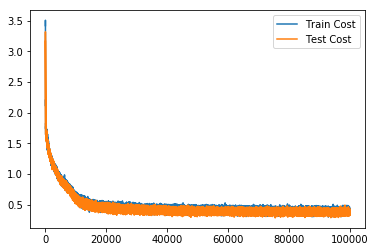

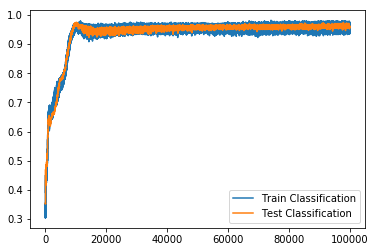

In [112]:
a.fit(X_train,y_train,lr=0.00001,epochs=10000,batch_size=490,n_batch=10,af=['sigmoid','leaky-relu','relu'])